## Evaluación del modelo

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score, 
    confusion_matrix, 
    precision_recall_curve,
    accuracy_score, 
    precision_score, 
    recall_score
)
    
from tabulate import tabulate
import numpy as np
import sys

In [2]:
sys.path.append("../..")

In [3]:
from src.utils.utils import (
    json_dump_dict,
    load_df
)
from src.utils.params import (
#     param_grid,
#     max_features,
#     n_estimators,
    evaluation_metric,
    feature_importance_theshold,
    tag_non_relevant_cats,
    ingestion_pickle_loc,
    transformation_pickle_loc,
    models_pickle_loc,
    X_train_pickle_loc,
    y_train_pickle_loc,
    X_test_pickle_loc,
    y_test_pickle_loc,
    test_predict_labs_pickle_loc,
    test_predict_scores_pickle_loc,
)


In [4]:
from src.pipelines.model_evaluation import (
    get_metrics_report,
    curva_roc,
    tabla_referencia,
    tabla_confusion,
    precision_at_k,
    recall_at_k,
    curva_pre_re,
    predicted_labels
)

- La tabla de métricas de tu mejor modelo
- La curva ROC
- La curva de precision y recall
- Las tablas de métricas obtenidas de la clase Group de Aequitas (conteos de frecuencias y absolutas)
- La visualización de tus 3 métricas seleccionadas con la salida de Group
- Las tablas de métricas obtenidas de la clase Bias de Aequitas (conteos de frecuencias y absolutas)
- La visualización de tus 3 métricas seleccionadas con la salida de Bias (disparidad)
- Las tablas de métricas obtenidas de la clase Fairness de Aequitas (conteos de frecuencias y absolutas)
- La visualización de tus 3 métricas seleccionadas con la salida de Fairness (equidad)

In [5]:
y_test = load_df("../../" +y_test_pickle_loc)

In [6]:
# predicciones con el mejor predictor 
predicted_scores = load_df("../../" +test_predict_scores_pickle_loc)

In [7]:
predicted_labels=predicted_labels(y_test,predicted_scores,0.18)

In [8]:
predicted_labels.shape

(414942,)

In [9]:
predicted_scores.shape

(414942, 2)

In [10]:
y_test.shape

(414942,)

## Métricas de desempeño

### ROC y AUC

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:,1], pos_label=1)

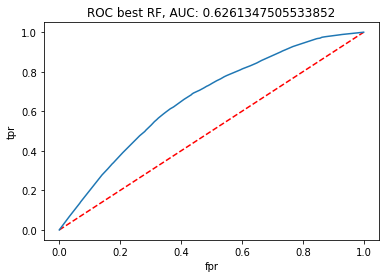

In [12]:
curva_roc(y_test,predicted_labels,fpr,tpr)

### Matriz de confusión

In [13]:
confu0=confusion_matrix(y_test, predicted_labels, normalize='all')
confu1=confusion_matrix(y_test, predicted_labels)

In [14]:
print(tabla_referencia())

Dato\Predicción    Etiqueta +           Etiqueta -
-----------------  -------------------  -------------------
Etiqueta +         True Positive (tp)   False Negative (fn)
Etiqueta -         False Positive (fp)  True Negative (tn)


In [15]:
print(tabla_confusion(confu0))

Dato\Predicción      Etiqueta +    Etiqueta -
-----------------  ------------  ------------
Etiqueta +            0.445988       0.349815
Etiqueta -            0.0629245      0.141273


In [16]:
print(tabla_confusion(confu1))

Dato\Predicción      Etiqueta +    Etiqueta -
-----------------  ------------  ------------
Etiqueta +               185059        145153
Etiqueta -                26110         58620


#### Accuracy

$$accuracy=\frac{\text{tp+tn}}{\text{tp+fp+tn+fn}}= \frac{\text{predichos correctamente}}{\text{total}}$$

#### Precision


$$precision=\frac{\text{tp}}{\text{tp+fp}}= \frac{\text{predichos positivos correctos}}{\text{predichos positivos}}$$

De los que identificamos como clase positiva, cuántos identificamos correctamente -pureza en nuestra predicción-. 

### Recall

$$recall=\frac{\text{tp}}{\text{tp+fn}}= \frac{\text{predichos positivos correctos}}{\text{datos positivos}}$$

Del universo posible de nuestra clase positiva, cúantos identificamos correctamente

#### F1-score

Combina precision y recall para obtimizar ambos.

$$F=2\cdot  \left( \frac{\text{precision}\cdot \text{recall}}{\text{precision + recall}} \right)$$

In [17]:
#### Accuracy
accuracy_score(y_test, predicted_labels)

0.5872603881988326

In [18]:
#### Precision, recall, thresholds
precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores[:,1], pos_label=1)

In [19]:
thresholds_2 = np.append(thresholds_2, 1)

In [20]:
(precision.shape, recall.shape, thresholds_2.shape)

((961,), (961,), (961,))

In [21]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.061789,0.204230,1.000000,0.339187,1.000000,0.999800,0.000200,0.000000
1,0.062372,0.204316,0.999953,0.339303,0.999953,0.999225,0.000775,0.000047
2,0.062452,0.204323,0.999941,0.339313,0.999941,0.999167,0.000833,0.000059
3,0.062490,0.204425,0.999823,0.339447,0.999823,0.998422,0.001578,0.000177
4,0.062552,0.204458,0.999799,0.339490,0.999799,0.998198,0.001802,0.000201
...,...,...,...,...,...,...,...,...
935,0.303305,0.341528,0.142323,0.200918,0.142323,0.070409,0.929591,0.857677
936,0.305946,0.340072,0.135607,0.193896,0.135607,0.067523,0.932477,0.864393
937,0.306196,0.339078,0.128172,0.186026,0.128172,0.064104,0.935896,0.871828
938,0.308563,0.345293,0.066671,0.111762,0.066671,0.032437,0.967563,0.933329


In [22]:
negocio = metrics_report[metrics_report.fpr <= 0.06]
negocio

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
938,0.308563,0.345293,0.066671,0.111762,0.066671,0.032437,0.967563,0.933329
939,0.309855,0.345156,0.059377,0.101323,0.059377,0.028906,0.971094,0.940623


In [23]:
punto_corte = negocio.head(1).threshold.values[0]
punto_corte

0.308562718472398

In [24]:
new_labels = [0 if score < punto_corte else 1 for score in predicted_scores[:,1]]

In [25]:
pd.Series(new_labels).sum()

16360

In [26]:
print(tabla_confusion(confusion_matrix(y_test, new_labels)))

Dato\Predicción      Etiqueta +    Etiqueta -
-----------------  ------------  ------------
Etiqueta +               319501         10711
Etiqueta -                79081          5649


In [27]:
print(tabla_confusion(confusion_matrix(y_test, predicted_labels)))

Dato\Predicción      Etiqueta +    Etiqueta -
-----------------  ------------  ------------
Etiqueta +               185059        145153
Etiqueta -                26110         58620


In [28]:
k=0.04

In [29]:
recall_at_k(y_test,predicted_scores[:,1],k)

0.12817183996223297

In [30]:
precision_at_k(y_test,predicted_scores[:,1],k)

0.3390783064818284

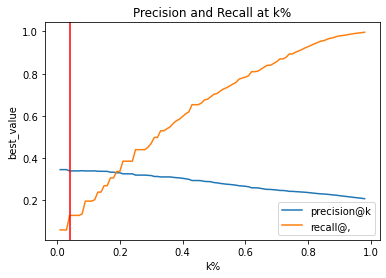

In [31]:
curva_pre_re(y_test, predicted_scores[:,1],k)

## Aequitas